# ATIVIDADE_03_PARTE_01
Alunas: Marília Meister (20250396) e Maria Natalia da Silva (17207797)

Nesta atividade vocês precisarão implementar o modelo gaussiano no Python. Vocês devem realizar os seguintes tópicos:
* Item01_Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas.

- Item02_Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade.

- Item03_Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant, Holland e Briggs (quem fizer o método de Briggs ganha um ponto a mais). Deve ser considerado o efeito Tip-Downwash

- Item04_Implementar a função do modelo gaussiano

- Item05_Realizar simulações com o script criado, utilizando diferentes classes de estabilidade, velocidades do vento, alturas de chaminé. Considere a taxa de emissão que você estimou na primeira atividade. Encontre a altura de chaminé necessária para que as concentrações não violem os padrões da Resolução CONAMA 491.

- Item06_Faça figuras e discuta os resultados.

## Item01_Implementar uma função para determinar a classe de estabilidade de Pasquil para diferentes condições atmosféricas.
Neste item, foi implementada uma função para determinar a classe de estabilidade de Pasquil utilizando a planilha gerada na atividade anterior do EZ-AERMOD. Os dados contidos nela são relevantes para essa classificação. Dessa maneira, para melhorar a avalição dos dados de 2023, propomos os seguintes passos:
 * 1° Selecionar um dia aleatório da tabela. Considerar, nessa seleção, as
   colunas de cobertura de nuvens, velocidade do vento e fluxo de calor sensível.
 * 2° Com auxílio de pesquisa, gerar a classificação de Pasquil avaliando os dados selecionados
 * 3° Apresentar os resultados.

In [138]:
#-----------------------------------------------------1° Selecionar um dia de cada mês do ano de 2023 da tabela do EZ-AERMOD.-----------------------------------------------------
import pandas as pd
import numpy as np

# Carregar a tabela do seu computador
caminho_arquivo = r'C:\Users\Marilia\Documents\ENS5173_202401\ENS5173_202401\inputs\ez_aermod_marilia\meteo_sfc_mod2.csv'

# Abrir o arquivo CSV como um DataFrame do pandas, especificando o encoding
data = pd.read_csv(caminho_arquivo, encoding='latin1')

# Selecionar apenas colunas numéricas para calcular a média diária
data_numeric = data.select_dtypes(include=[np.number])

# Incluir a coluna 'dia' no DataFrame data_numeric
data_numeric[['ano', 'mês', 'dia']] = data[['ano', 'mês', 'dia']]

# Calcular a média diária dos valores para cada coluna numérica
data_diaria = data_numeric.groupby(['ano', 'mês', 'dia']).mean().reset_index()

# Selecionar um dia aleatório de todo o ano com as colunas desejadas
dia_aleatorio = data_diaria.sample(1)[['ano', 'mês', 'dia', 'cob_nuvens', 'velo_vento[m/s]', 'calor_sens [W/m2]']]

#----------------------------------------------2° Gerar a classificação de Pasquil avaliando os dados selecionados-----------------------------------------------------------------
def pasquil (data):

    radiacao = data['calor_sens [W/m2]'] 
    vel_vento = data['velo_vento[m/s]']
    cob_nuvens = data['cob_nuvens']
    hora = data['hora']

    print (hora)
    
    if 7 <= hora <= 18: #Durante o dia

        if radiacao > 700:
            if vel_vento < 2:
                return 'A'
            elif 2 <= vel_vento < 3:
                return 'A - B'
            elif 3 <= vel_vento < 5:
                return 'B'
            elif 5 <= vel_vento < 6:
                return 'C - D'
            else:
                return 'D'
        elif 350 < radiacao <= 700:
            if velocidade_vento < 2:
                return 'A - B'
            elif 2 <= vel_vento < 3:
                return 'B'
            elif 3 <= vel_vento < 5:
                return 'B - C'
            elif 5 <= vel_vento < 6:
                return 'C - D'
            else:
                return 'D'
        elif radiacao <= 350:
            if vel_vento < 2:
                return 'B'
            elif 2 <= vel_vento < 3:
                return 'B - C'
            elif 3 <= vel_vento < 5:
                return 'C'
            elif 5 <= vel_vento < 6:
                return 'C - D'
            else:
                return 'D'
    
    elif 7 > hora > 18: #Durante o dia
        if cob_nuvens is None:
            return 'Parâmetro de cobertura de nuvens é necessário durante a noite.'
    
        if cob_nuvens >= 4/8:
            if vel_vento < 2:
                return 'E'
            elif 2 <= vel_vento < 3:
                return 'E'
            elif 3 <= vel_vento < 5:
                return 'D'
            elif 5 <= vel_vento < 6:
                return 'D'
            else:
                return 'D'
        elif cob_nuvens < 3/8:
            if vel_vento < 2:
                return 'F'
            elif 2 <= vel_vento < 3:
                return 'E'
            elif 3 <= vel_vento < 5:
                return 'D'
            elif 5 <= vel_vento < 6:
                return 'D'
            else:
                return 'D'
    
    return 'Parâmetros inválidos. Verifique os valores fornecidos.'    
#-------------------------------------------------------------3° Apresentar a tabela de resultados.--------------------------------------------------------------------------------

# Aplicar a função para determinar a classe de estabilidade de Pasquil para o dia selecionado
dia_aleatorio['classe_pasquil'] = dia_aleatorio.apply(determinar_classe_estabilidade, axis=1)

# Exibir o dia aleatório selecionado com a classe de estabilidade de Pasquil
display(dia_aleatorio)

,ano,mês,dia,cob_nuvens,velo_vento[m/s],calor_sens [W/m2],classe_pasquil
285,23,10,13,7.833333,5.058333,21.15,F


## Item02_Implementar a função de estimativa de coefiente de dispersão (sigmaYZ) para todas as classes de estabilidade.
Neste item foi criada uma função para estimar cada classe de estabilidade de Pasquil. As fórmulas de sigmaY e sigmaZ foram
retiradas da tabela apresentada em aula.  

In [140]:
# Criando função da estimativa da dispersão lateral e vertical da pluma
def sigmaXY(x, classe, urbOrRural):
    
    if urbOrRural == 'urbano':
        if classe in ['A', 'B']:
            sigmaY = 0.32 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.24 * x * (1 + 0.001 * x) ** (0.5)
        elif classe == 'C':
            sigmaY = 0.22 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'D':
            sigmaY = 0.16 * x * (1 + 0.0004 * x) ** (-0.5)
            sigmaZ = 0.14 * x * (1 + 0.0003 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        elif classe == 'F':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0015 * x) ** (-0.5)
        else:
            print('Classe de estabilidade errada')
    elif urbOrRural == 'rural':
        if classe == 'A':
            sigmaY = 0.22 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.20 * x
        elif classe == 'B':
            sigmaY = 0.16 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.12 * x
        elif classe == 'C':
            sigmaY = 0.11 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.08 * x * (1 + 0.0002 * x) ** (-0.5)
        elif classe == 'D':
            sigmaY = 0.08 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.06 * x * (1 + 0.0015 * x) ** (-0.5)
        elif classe == 'E':
            sigmaY = 0.06 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.03 * x * (1 + 0.0003 * x) ** (-1)
        elif classe == 'F':
            sigmaY = 0.04 * x * (1 + 0.0001 * x) ** (-0.5)
            sigmaZ = 0.016 * x * (1 + 0.0003 * x) ** (-1)
        else:
            print('Classe de estabilidade errada. Fique ligado')
    else:
        print('Tipo de região errada. Use "urbano" ou "rural".')
    
    return sigmaY, sigmaZ

## Item03_Implementar a função de estimativa de sobrelevação da pluma utilizando os métodos de Davidson-Bryant e Holland. Deve ser considerado o efeito Tip-Downwash

In [141]:
# Função para estimar o deltaH com base na equação de Davidson-Bryant
def deltaHdavidsonBryant(d, vs, u, Ts, Tamb, hg):
    if vs > 1.5 * u:
        deltaH = (d * (vs / u)**(1.4)) * (1 + (Ts - Tamb) / Ts)
        hef = hg + deltaH
        print('Sobrelevação da pluma (deltaH): ' + str(deltaH))
        print('A pluma subiu')
    else:
        hef = hg + 2 * d * ((vs / u) - 1.5)
        print('A pluma caiu')
   
    return hef

# Função para estimar o deltaH com base na equação de Holland
def deltaHholland(d, vs, u, Ts, Tamb, p, estabilidade):
    deltaH = (d * vs / u) * (1.5 + 2.68 * 10**-3 * p * (Tamb / Ts) * d)
    
    # Ajuste para condições de estabilidade
    if estabilidade == 'instável':
        deltaH *= 1.2  # Aumento de 20%
    elif estabilidade == 'estável':
        deltaH *= 0.8  # Redução de 20%
    
    return deltaH

# Função principal para estimar a sobrelevação da pluma
def estimar_sobrelevacao_pluma(d, vs, u, Ts, Tamb, p, estabilidade, metodo, hg, tip_downwash=False):
    if metodo == 'Davidson-Bryant':
        hef = deltaHdavidsonBryant(d, vs, u, Ts, Tamb, hg)
    elif metodo == 'Holland':
        deltaH = deltaHholland(d, vs, u, Ts, Tamb, p, estabilidade)
        if tip_downwash:
            # Considerando uma redução típica de 10% devido ao efeito Tip-Downwash
            deltaH *= 0.9
        hef = hg + deltaH
    else:
        raise ValueError("Método não reconhecido. Use 'Davidson-Bryant' ou 'Holland'.")
    
    return hef

## Item04_Implementar a função do modelo gaussiano

In [142]:
# Criando uma função do modelo gaussiano
import numpy as np
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H):
    termo1 = qs/(2*np.pi*sigmaY*sigmaZ*u)
    termo2 = np.exp((-y**2)/(2*sigmaY**2))
    termo3 = np.exp((-(z-H)**2)/(2*sigmaZ**2)) + np.exp((-(z+H)**2)/(2*sigmaZ**2))
    conc = termo1*termo2*termo3
    conc = conc*10**6
    return conc

## Item05_Realizar simulações com o script criado
Neste item é apresentado: 
* 01 _ Classe de estabilidade encontrada no primeiro item. Posteriormente esse resultado é usado no parametro "classe" para fazer 
os calculos de sigmaY e sigmaZ, pela função definida no segundo anteriormente no presente código. [testar novas classes como pede o enunciado]
* 02 _ A sobrelevação está sendo calculada pelo método de Davidson-Bryant. Aqui posso testar novos valores dos seguintes parâmetros como pedido no enunciado:
   - Velocidade do vento (u);
   - Altura da chaminé (hg);
* 03_ Concentração pontual usado a equação Gaussina. Aqui devo usar os valores encontrados na atividade 1 de emissões, nesse caso:
   - PM = 71,48 (g/s)
   - SO2 = 16010.53 (g/s)
   - NOX = 41.37 (g/s)

In [143]:
# 01 Exibindo a classificação encontrada para o dia aletório encontrado no início do código e calculando os coeficientes de dispersão 

print(f"Classe de estabilidade de Pasquill: {dia_aleatorio['classe_pasquil'].values[0]}")

# Definir os parâmetros de entrada
x = 1000  # Distância da fonte de emissão em metros
classe = 'F'  # Classe de estabilidade da atmosfera
urbOrRural = 'urbano'  # Tipo de região ('urbano' ou 'rural') Para o nosso caso, notamos no trabalho 2 
                       # que a empresa Portobello está inserida em região Urbana

# Chamar a função para calcular sigmaY e sigmaZ
sigmaY, sigmaZ = sigmaXY(x, classe, urbOrRural)

# Exibir os resultados
print(f'sigmaY: {sigmaY} m')
print(f'sigmaZ: {sigmaZ} m')

Classe de estabilidade de Pasquill: F
sigmaY: 104.88088481701514 m
sigmaZ: 50.59644256269407 m


In [144]:
# 02 Apresentando a sobrelevação da pluma considerando o método Davidson-Bryant -------------------------------------------------

#Dados de entrada
d = 1.0  # Exemplo de valor [diâmetro interno da chaminé (m)]
vs = 5.05 # Foi apresentado no início do código [velocidade do efluente na saída da chaminé (m/s)]
u = 2.0  # Exemplo de valor [velocidade do vento a 10 metros (m/s)]
Ts = 300.0  # Exemplo de valor [temperatura do gás na saída da chaminé (K)]
Tamb = 290.0  # Exemplo de valor [temperatura ambiente (K)]
p = 1009  # valor que aparece na tabela do EZ-AERMOD [pressão ATM em mb] (habilitar se estiver usando o método Holland)
estabilidade = 'instavel'  # Exemplo de condição de estabilidade (habilitar se estiver usando o método Holland)
metodo = 'Davidson-Bryant'  # Escolha entre 'Davidson-Bryant' e 'Holland'
tip_downwash = True  # Considerar o efeito Tip-Downwash
hg = 150 # Exemplo de valor [altura da chaminé (m)]

hef = estimar_sobrelevacao_pluma(d, vs, u, Ts, Tamb,p, estabilidade, metodo, hg, tip_downwash)
print(f'A altura efetiva da chaminé (H): {hef}', '[m]')

Sobrelevação da pluma (deltaH): 3.77925655093708
A pluma subiu
A altura efetiva da chaminé (H): 153.77925655093708 [m]


In [145]:
# 03_Concentração pontual usado a equação Gaussina  -----------------------------------------------------

# Utilizando a função do modelo gaussiano
qs = 71.48 # g/s usar as emissões calculadas na primeira atividade [PM = 71,48, SO2 = 16010.53, NOX = 41.37] 
sigmaY = 104.88 # m [coeficiente de dispersão] (usar o sigmaY calculado no item 01)
sigmaZ = 50.59 # m [coeficiente de dispersão] (usar o sigmaZ calculado no item 01)
u = 2 # m/s [velocidade média do vento] (usar o mesmo valor escolhido no item 02)
y = 0 # estimando na direção do vento [dist. horizontal do eixo central da pluma]
z = 1.5  # altura do nariz [dist. acima do solo]
H = 153.83 # m usando o valor estimado no calculo [altura efetiva da chaminé] 

# Chamando a função do modelo gaussiano
conc = modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,H)

print("Polunente avaliado é o PM")
print("A concentração estimada é = " +str(conc) + ' [μg/m³]')

Polunente avaliado é o PM
A concentração estimada é = 21.13883761908531 [μg/m³]


## Item06_Faça figuras e discuta os resultados.

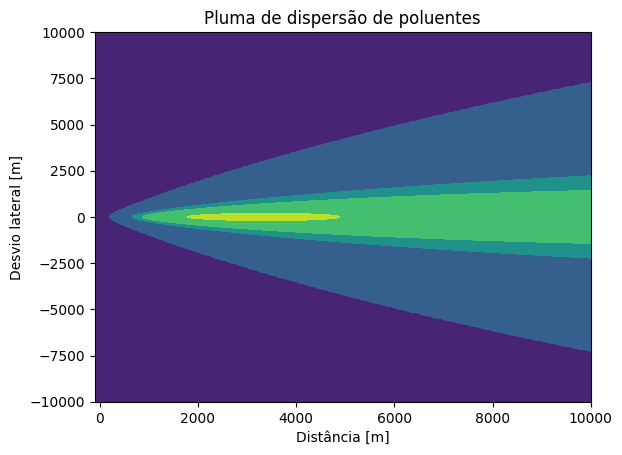

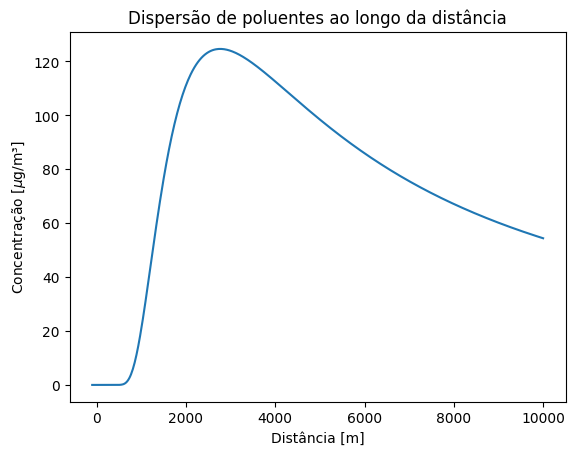

In [147]:
# Criando domínio de modelagem 
x = np.linspace(-100,10000,500)
#print(x)
y = np.linspace(-10000,10000,500)

# Criando matrizes de x e y
xx,yy = np.meshgrid(x,y)
#print(xx.shape)

# Estimando o coeficiente de dispersão lateral e vertical
sigmaY,sigmaZ = sigmaXY(xx,classe,urbOrRural)
#print(sigmaY)

# Utilizando a matriz de yy como input na função do modelo gaussiano
conc = modeloGaussiano(qs,sigmaY,sigmaZ,u,yy,z,hef)

# Visualização dos resultados no espaço
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig,ax = plt.subplots()
ax.contourf(xx,yy,conc+0.1,norm = LogNorm())

plt.xlabel('Distância [m]')
plt.ylabel('Desvio lateral [m]')
plt.title('Pluma de dispersão de poluentes')
plt.show()

# Corte em y - sobre o eixo x
fig,ax = plt.subplots()
ax.plot(x,conc[250,:])
plt.xlabel('Distância [m]')
plt.ylabel('Concentração [$\mu$g/m³]')
plt.title('Dispersão de poluentes ao longo da distância')
plt.show()

## Os testes foram realizados e estão apresentados em planilha separada, enviada junto com o arquivo deste código no moodle!!
Lembrando que será melhor detalhado no relatório final junto com a segunda etapa da presente atividade 